# Validate parquet files

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from plantclef.utils import get_spark

spark = get_spark()
display(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/24 20:00:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/03/24 20:00:26 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [3]:
# Get list of stored filed in cloud bucket
root = "gs://dsgt-clef-plantclef-2024"
! date
! gcloud storage ls {root}/data/parquet_files

Sun Mar 24 20:00:28 UTC 2024
gs://dsgt-clef-plantclef-2024/data/parquet_files/
gs://dsgt-clef-plantclef-2024/data/parquet_files/PlantCLEF2022_web_training_images_1/
gs://dsgt-clef-plantclef-2024/data/parquet_files/PlantCLEF2022_web_training_images_4/
gs://dsgt-clef-plantclef-2024/data/parquet_files/PlantCLEF2024_training/
gs://dsgt-clef-plantclef-2024/data/parquet_files/PlantCLEF2024_training_cropped_resized/


In [4]:
# Path and dataset names
gcs_path = "gs://dsgt-clef-plantclef-2024/data/parquet_files/"
train = "PlantCLEF2024_training_cropped_resized"

# Define the GCS path to the Train parquet file
train_gcs_path = f"{gcs_path}{train}"

# Read the Parquet file into a DataFrame
train_df = spark.read.parquet(train_gcs_path)

# Show the data (for example, first few rows)
train_df.show(n=3)

+--------------------+--------------------+--------------------+------+----------+----------+--------+-------+--------------------+--------+-----------------+------------------+---------------+--------------------+---------+-------------+--------+---------+--------------------+--------------------+---------+--------------------+--------------------+
|          image_name|                path|                data| organ|species_id|    obs_id| license|partner|              author|altitude|         latitude|         longitude|gbif_species_id|             species|    genus|       family| dataset|publisher|          references|                 url|learn_tag|    image_backup_url|  cropped_image_data|
+--------------------+--------------------+--------------------+------+----------+----------+--------+-------+--------------------+--------+-----------------+------------------+---------------+--------------------+---------+-------------+--------+---------+--------------------+------------------

### display images

In [5]:
import io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


def display_images_from_binary(image_data_list, binomial_names, grid_size=(3, 3)):
    """
    Display images in a grid with binomial names as labels.

    :param image_data_list: List of binary image data.
    :param binomial_names: List of binomial names corresponding to each image.
    :param grid_size: Tuple (rows, cols) representing the grid size.
    """
    # Unpack the number of rows and columns for the grid
    rows, cols = grid_size

    # Create a matplotlib subplot with the specified grid size
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12), dpi=80)

    # Flatten the axes array for easy iteration if it's 2D
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    for ax, binary_data, name in zip(axes, image_data_list, binomial_names):
        # Convert binary data to an image and display it
        image = Image.open(io.BytesIO(binary_data))
        ax.imshow(image)
        name = name.replace("_", " ")
        ax.set_xlabel(name)  # Set the binomial name as xlabel
        ax.xaxis.label.set_size(14)  # Set the font size for the xlabel
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()

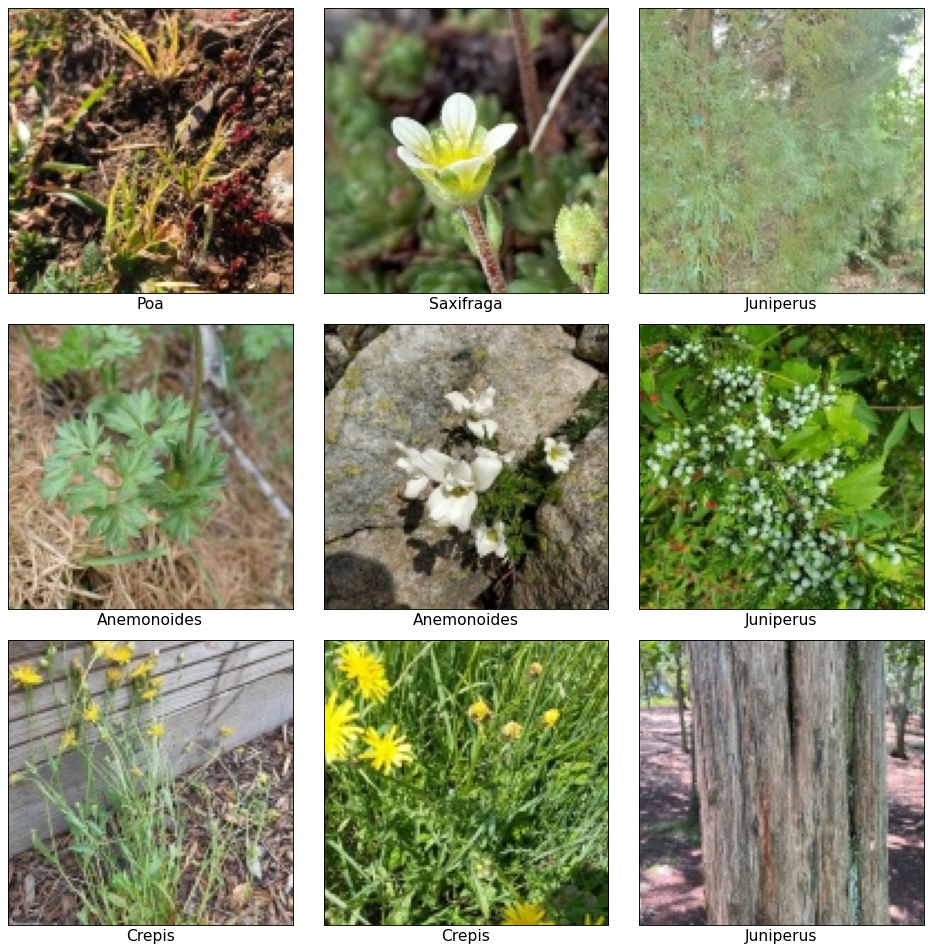

In [6]:
# Collect binary image data from DataFrame
rows, cols = 3, 3
image_data_list = [
    row["cropped_image_data"] for row in train_df.limit(rows * cols).collect()
]
binomial_names = [row["genus"] for row in train_df.limit(rows * cols).collect()]

# Display the images in a grid with binomial names
display_images_from_binary(image_data_list, binomial_names, grid_size=(3, 3))

In [ ]:
train_df.count()